<a href="https://colab.research.google.com/github/arizonaCameraLab/computationalImaging/blob/master/Chapter8FocalImaging/2DCohererenceTransferFuction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coherence transfer function of a circular aperture
## David Brady
## with extensive use of ChatGPT 01 pro
## February 2025

# Summary of the discussion with ChatGPT

In this conversation, we explored the following main points:

1. **Definition of a Circular Characteristic Function**  
   We defined `circ(x, y)` to be $1$ if $(x, y)$ lies within a circle of radius $0.5$ (centered at the origin) and $0$ otherwise. Mathematically:
   $$
       \text{circ}(x, y) =
       \begin{cases}
         1 & \text{if } x^2 + y^2 \le 0.25,\\
         0 & \text{otherwise}.
       \end{cases}
$$

2. **Definition and Numerical Evaluation of $q(x', x)$**  
   The function
   $$
     q(x', x) \;=\; \int_{-\infty}^{+\infty} \text{circ}\bigl(x' + \tfrac{x}{2},\,y\bigr)\,\text{circ}\bigl(x' - \tfrac{x}{2},\,y\bigr)\,dy
   $$
   was computed numerically by:
   - Restricting the integral over $y$ to a finite interval (e.g., $[-1,1]$) since values outside contribute negligibly when the circles have radius $0.5$.
   - Using a simple trapezoidal rule (`numpy.trapz`) to approximate the integral.
   - Evaluating on a grid of $(x', x)$ values.

3. **Plotting $q(x', x)$**  
   We generated a 2D grid of $(x', x)$ points and computed $q$ at each grid point:
   - $x'$ was typically restricted to $\lvert x' \rvert \le 0.5$.
   - $x$ might range in $[-1,1]$ (or another chosen interval).
   - A density plot (`pcolormesh`) or contour plot was used to visualize $q(x', x)$.

4. **Fourier Transform $\mathcal{F}\{q\}$ with Respect to $x'$**  
   We then discussed taking a **discrete Fourier transform (DFT)** (via `numpy.fft.fft`) of $q$ **in the $x'$ dimension**:
   - For each fixed $x$, compute the 1D DFT of $q(\,\cdot\,, x)$ over the array of sampled $x'$ values.
   - The resulting function $H(\nu, x)$ was then **re-scaled** to physically meaningful coordinates:  
     $$
       \Delta x = \nu \,(\lambda F), \quad
       u = \frac{x}{\lambda F},
     $$
     where $\lambda$ is the wavelength, and $F$ is the focal length.

5. **Plotting $H(u, \Delta x)$**  
   - We formed a 2D plot of $H(u, \Delta x)$ in the **positive quadrant** $(u \ge 0, \Delta x \ge 0)$.  
   - We used `fftshift` and frequency arrays (`np.fft.fftfreq`) to map discrete Fourier indices to actual $\Delta x$ values.  
   - To get **cross-sections** of $H$ at particular $\Delta x$ (e.g., 0, 0.25, 0.5, 1), we found the array index closest to each desired $\Delta x$ and plotted $H(u)$ vs. $u$.

6. **Implementation Details**  
   - **Discrete Spacing** in $x'$: The step size $\Delta x'$ is used for the Fourier transform frequency scale.  
   - **FFT Shifting**: We employed `np.fft.fftshift` to center the zero frequency in the middle of the array.  
   - **Magnitude or Intensity**: In many optical contexts, one might take the magnitude (or squared magnitude) of the FFT result. This depends on whether the goal is amplitude or intensity.

7. **Practical Considerations**  
   - Choice of the integration limits for $y$.  
   - Discretization resolutions in $x'$, $x$, and $y$.  
   - Physical scaling parameters ($\lambda$, $f/\#$, aperture size $A$, etc.) influence the final plots.  
   - Ensuring axis labels match the intended domain (i.e., labeling $u$ vs. $\Delta x$ consistently).

Overall, the conversation detailed how to:

- Define and compute $q(x', x)$ for a particular kernel (`circ`).
- Plot $q$ as a function of $(x', x)$.
- Take a 1D DFT in $x'$, scale frequency to $\Delta x$, and scale $x$ to $u$.
- Visualize the transformed function $H(u, \Delta x)$ in both a 2D density plot and through cross-sections for specific $\Delta x$ values.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size']= 18


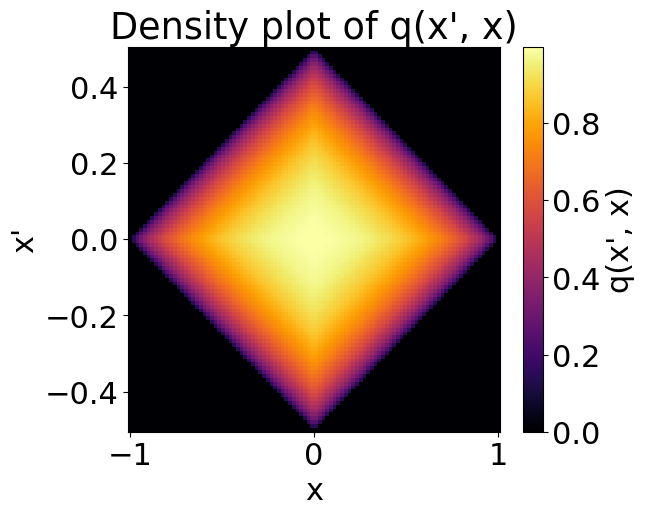

In [ ]:


def circ(x, y):
    """
    Characteristic function of a disk of radius 0.5 centered at the origin.
    Returns 1 if sqrt(x^2 + y^2) <= 0.5, 0 otherwise.
    """
    r2 = x**2 + y**2
    return 1.0 if r2 <= 0.25 else 0.0

def q(xp, x, y_min=-1.0, y_max=1.0, num_points=1001):
    """
    Numerically approximate:
        q(xp, x) = ∫ circ(xp + x/2, y) * circ(xp - x/2, y) dy
    over y in [y_min, y_max], using trapezoidal rule.
    """
    ys = np.linspace(y_min, y_max, num_points)
    # Evaluate the integrand for each y
    integrand = [
        circ(xp + x/2.0, y) * circ(xp - x/2.0, y)
        for y in ys
    ]

    return np.trapz(integrand, ys)

# ---- Set up a grid of (x', x) values ----
# Restrict |x'| <= 0.5, and |x| <= 1.0 as an example.
num_xp = 100
num_x  = 100

xp_vals = np.linspace(-0.5, 0.5, num_xp)   # x' in [-0.5, 0.5]
x_vals  = np.linspace(-1.0, 1.0, num_x)   # x in [-1, 1]

# We'll make a 2D array Q with Q[i, j] = q(xp_vals[i], x_vals[j]).
Q = np.zeros((num_xp, num_x))

for i, xp_ in enumerate(xp_vals):
    for j, x_ in enumerate(x_vals):
        Q[i, j] = q(xp_, x_)

# ---- Create meshgrid so that X_grid is "x" along the horizontal axis,
#      and XP_grid is "x'" along the vertical axis. ----
X_grid, XP_grid = np.meshgrid(x_vals, xp_vals)  # note the order

# ---- Make a 2D density plot of Q ----
plt.figure(figsize=(6, 5))
plt.pcolormesh(X_grid, XP_grid, Q, shading='auto', cmap='inferno')
plt.colorbar(label='q(x\', x)')
plt.xlabel('x')
plt.ylabel("x'")
plt.title("Density plot of q(x', x)")
plt.show()


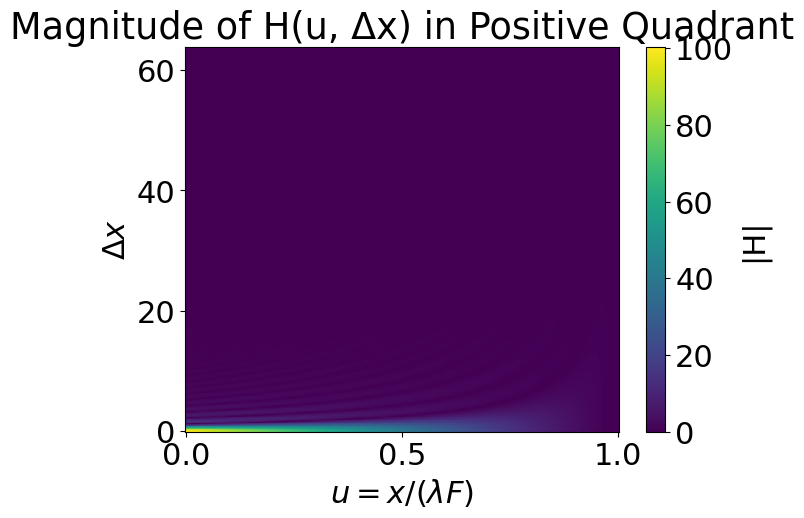

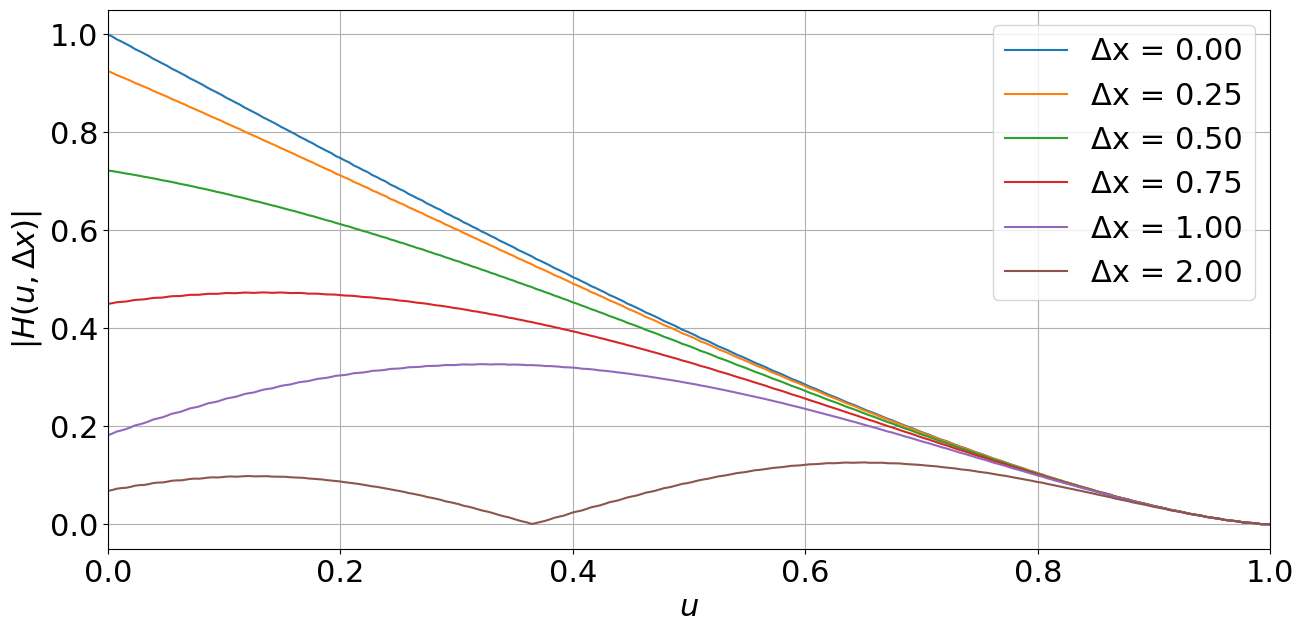

In [ ]:


##############################################################################
# 1) Define parameters and the function q(x', x)
##############################################################################

# Physical parameters (placeholders; adjust as needed)
lambda_ = 1.0  # wavelength λ (choose consistent units)
A       = 1.0  # aperture dimension
fnum    = 1.0  # f-number
F       = A / fnum  # focal length or relevant scaling

# Domain in x' and x
#   Suppose we consider x' in [-0.5, 0.5] (where circ is mostly nonzero).
#   Suppose x in [0, 1], so we look at positive x only.
n_xp = 1024
n_x  = 256
xprime_min, xprime_max = -4, 4
x_min, x_max = 0.0, 1.0  # positive x only
xp_vals = np.linspace(xprime_min, xprime_max, n_xp)
x_vals  = np.linspace(x_min, x_max, n_x)

# Example circ function
def circ(x, y):
    # Characteristic function of a disk of radius 0.5 centered at (0,0).
    return 1.0 if (x**2 + y**2) <= 0.25 else 0.0

def q(xp, x, n_y=501, y_min=-1.0, y_max=1.0):
    """
    Numerically evaluate:
        q(xp, x) = ∫ circ(xp + x/2, y)*circ(xp - x/2, y) dy
    using a simple trapezoidal rule in y.
    """
    ys = np.linspace(y_min, y_max, n_y)
    integrand = [
        circ(xp + x/2.0, y)*circ(xp - x/2.0, y) for y in ys
    ]
    return np.trapz(integrand, ys)

# Build the 2D array Q of shape (n_xp, n_x)
Q = np.zeros((n_xp, n_x), dtype=np.float64)
for i, xp in enumerate(xp_vals):
    for j, xx in enumerate(x_vals):
        Q[i, j] = q(xp, xx)

##############################################################################
# 2) Discrete Fourier Transform of q w.r.t. x' (for each x)
#    We'll use numpy.fft.fft to do an FFT along the x' dimension (rows).
##############################################################################

# 2A) Spacing in x'
dxp = (xprime_max - xprime_min) / (n_xp - 1)

# 2B) Perform FFT along axis=0 (the xp-axis)
#     H_fft[k, j] ~ sum_over_i Q[i,j] * exp(-2πi * freq_k * xp_i) * dxp
#     with freq_k from np.fft.fftfreq(...) or we can use fftshift.
H_fft = np.fft.fftshift(np.fft.fft(Q, axis=0), axes=(0,))
# H_fft now has shape (n_xp, n_x), with frequencies in fftshifted order

# 2C) Construct frequency axis 'freqs' in cycles per unit of x'
freqs = np.fft.fftshift(np.fft.fftfreq(n_xp, d=dxp))  # length n_xp

# 2D) Rescale frequency to get Δx
#     Δx = freq * (λ F)
Delta_x_vals = freqs * (lambda_ * F)

# 2E) Convert x to u = x / (λ F)
u_vals = x_vals / (lambda_ * F)

##############################################################################
# 3) Build a 2D "H" array in (Δx, u).
#    Right now, H_fft is indexed as H_fft[freq_index, x_index].
#    We can interpret that as H( Delta_x_vals[freq_index], u_vals[x_index] ).
##############################################################################
# Typically the raw FFT is complex. Often in optics, one might take the magnitude
# or intensity. Adjust as needed: amplitude = np.abs(...), intensity = amplitude**2
H_mag = np.abs(H_fft)

##############################################################################
# 4) Restrict to the positive quadrant: Δx >= 0, u >= 0
##############################################################################
# Positive freq:  freq >= 0  =>  Delta_x >= 0
# We already have x>=0, so u>=0 by design.
pos_freq_mask = (Delta_x_vals >= 0)
Delta_x_pos = Delta_x_vals[pos_freq_mask]
H_pos       = H_mag[pos_freq_mask, :]  # shape (nPosFreq, n_x)

# We have u_vals in [0, (x_max)/(λF)], which is already non-negative.

##############################################################################
# 5) Make a surface or 2D color plot of H in (u, Δx) space for the positive quadrant
##############################################################################
# We'll meshgrid so that:
#   horizontal axis = u
#   vertical axis   = Delta_x
Delta_x_grid, u_grid = np.meshgrid(Delta_x_pos, u_vals, indexing='ij')
# indexing='ij' means:
#   Delta_x_grid[i, j] = Delta_x_pos[i]
#   u_grid[i, j]       = u_vals[j]
# Meanwhile, H_pos has shape (len(Delta_x_pos), len(x_vals)) => (i, j).

plt.figure(figsize=(7,5))
plt.pcolormesh(u_grid, Delta_x_grid, H_pos, shading='auto', cmap='viridis')
plt.xlabel(r'$u = x / (\lambda F)$')
plt.ylabel(r'$\Delta x$')
plt.title('Magnitude of H(u, Δx) in Positive Quadrant')
plt.colorbar(label='|H|')
plt.show()

##############################################################################
# 6) Plot cross sections of H vs. u for Δx = 0, 0.25, 0.5, 1
#    We'll find the freq index in Delta_x_pos that is closest to each desired value
##############################################################################
desired_Dx = [0.0, 0.25, 0.5, .75, 1, 2]
plt.figure(figsize=(15,7))

for val in desired_Dx:
    # Find index in Delta_x_pos that is closest to 'val'
    idx = np.argmin(np.abs(Delta_x_pos - val))
    label_str = f"Δx = {Delta_x_pos[idx]:.2f}"
    plt.plot(u_vals, H_pos[idx,:]/np.max(H_pos), label=label_str)

plt.xlim([0, 1/(lambda_*fnum)])  # or whichever range you want for u
plt.xlabel(r'$u $')
plt.ylabel(r'$|H(u,\Delta x)|$')
#plt.title("Cross-sections of H vs. u at selected Δx")
plt.legend()
plt.grid(True)
plt.savefig('coherenceTransfer.pdf')

# Problem Description and Visualization in Fourier Space

We consider the function

$$
q(x', y'; u) \;=\; \text{circ}\bigl(x' + \tfrac{u}{2},\,y'\bigr)\,\text{circ}\bigl(x' - \tfrac{u}{2},\,y'\bigr),
$$

where $\text{circ}(x, y)$ is the **characteristic function** of a disk of radius $0.5$ centered at the origin:

$$
\text{circ}(x, y)
  =
  \begin{cases}
    1, & \text{if } x^2 + y^2 \le 0.25,\\
    0, & \text{otherwise}.
  \end{cases}
$$

We interpret $x'$ and $y'$ as spatial coordinates in units of some characteristic length $A$. Consequently, each of $x'$ and $y'$ can range from $-1\,A$ to $+1\,A$, and $u$ is similarly in units of $A$.

---

## Goal:  
1. **Compute** the 2D Discrete Fourier Transform (DFT) of $q$ with respect to $(x', y')$.  
2. **Visualize** the **normalized amplitude** of the DFT over a specified range of spatial frequencies $\Delta x$ and $\Delta y$ in $\text{[1/A]}$.  
3. **Compare** the results for different displacements $u\in\{0,0.5,0.75\}$.

---

## Steps and Method

1. **Set up the $(x',y')$ Grid**  
   - We choose a grid of size $\text{Nx}\times\text{Ny}$ points, each $(x_i', y_j')$ spanning $[-1\,A, +1\,A]\times[-1\,A, +1\,A]$.  
   - By increasing $\text{Nx}, \text{Ny}$, we refine the spatial sampling and broaden the maximum non‐aliased frequency range.

2. **Evaluate $q(x', y'; u)$ on the Grid**  
   - For each point $(x_i', y_j')$, we compute the function
     $$
       q\bigl(x_i', y_j'; u\bigr)
         \;=\;
         \text{circ}\!\Bigl(x_i' + \tfrac{u}{2},\, y_j'\Bigr)\,\text{circ}\!\Bigl(x_i' - \tfrac{u}{2},\, y_j'\Bigr).
     $$

3. **2D Discrete Fourier Transform**  
   - We apply `numpy.fft.fft2` to compute the 2D FFT of the sampled array $Q$.  
   - The spatial sampling intervals $\Delta x'=\mathrm{dxp}$ and $\Delta y'=\mathrm{dyp}$ are in [$A$], so the resulting frequency axes are naturally in $[1/A]$.  
   - Using `fftshift`, we recenter the zero frequency to the middle of each axis.

4. **Normalization**  
   - We compute the **peak amplitude** of the FFT when $u=0$.  
   - For each subsequent $u$, we normalize the FFT amplitude by that same peak, enabling a direct comparison across subplots.

5. **Cropping the Frequency Domain**  
   - We plot only the region $[-5, 5]\times[-5, 5]$ $\text{[1/A]}$.  
   - This helps focus on the range of interest in frequency space.  

6. **3D Surface Plot**  
   - We construct a $1\times 3$ grid of 3D surface plots (using `matplotlib` and `Axes3D`):  
     - **Columns** represent $u=0$, $u=0.5$, and $u=0.75$.  
   - On each subplot, the **horizontal plane** is $\Delta x$ vs. $\Delta y$ in $\text{[1/A]}$, and the **vertical axis** is the **normalized amplitude** of the 2D FFT.

---

## Summary of the Physical Meaning

- **Real‐space coordinates** $(x', y')\in [-1\,A, +1\,A]^2$.  
- **Function** $q$ is the product of two circular apertures, offset in the $x$-direction by $\pm u/2$.  
- **Fourier space** ($\Delta x, \Delta y$) has units of [$1/A$], i.e., inverse length.  
- By **adjusting $u$**, we effectively shift these two circular disks horizontally, which changes their overlap and thus alters the shape of the resulting 2D FFT.  
- **Plot**: the 3D visualization shows how the FFT magnitude (normalized) depends on frequency for each $u$.  

In conclusion, by **increasing** `Nx, Ny`, we maintain the same **physical units** of $\Delta x, \Delta y$ in $\text{[1/A]}$, but **increase** resolution in both real space and frequency space. We then **crop** to $[-5,5]\times[-5,5]$ $[1/A]$ to reveal the most significant features of the transform.


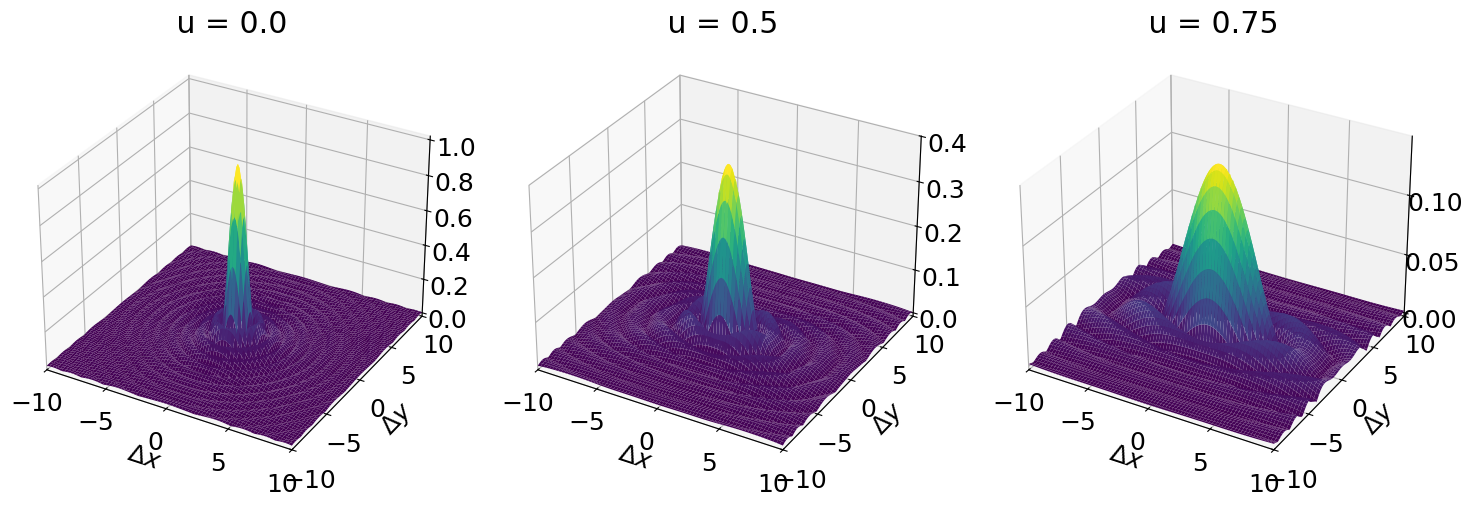

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # for 3D surface plots

###############################################################################
# 1) Define circ and q(x', y', u)
###############################################################################
def circ(x, y):
    """
    Characteristic function of a disk of radius 0.5 at the origin.
    Returns 1 if x^2 + y^2 <= 0.25, 0 otherwise.
    """
    return 1.0 if (x**2 + y**2) <= 0.25 else 0.0

def q(xp, yp, u):
    """
    q(x', y') = circ(x' + u/2, y') * circ(x' - u/2, y')

    Here x', y', and u are understood to be in units of A.
    That is, x' and y' each range over [-1 A, +1 A],
    and u is likewise in A.
    """
    return circ(xp + u/2.0, yp) * circ(xp - u/2.0, yp)

###############################################################################
# 2) Grid setup in (x', y') (both in units of A), and a function to compute the 2D FFT
###############################################################################
# You can vary Nx, Ny to increase resolution. Frequencies stay in 1/A.
Nx = 1024
Ny = 1024

# Coordinate ranges for x' and y' in units of A
xprime_min, xprime_max = -4.0, 4.0
yprime_min, yprime_max = -4.0, 4.0

xp_vals = np.linspace(xprime_min, xprime_max, Nx)
yp_vals = np.linspace(yprime_min, yprime_max, Ny)

# Spacing in x' and y' (units of A)
dxp = (xprime_max - xprime_min) / (Nx - 1)
dyp = (yprime_max - yprime_min) / (Ny - 1)

def compute_fft2_of_q(u):
    """
    Build q(x', y') for a given u, then compute its 2D FFT, shift it,
    and return (Delta_x, Delta_y, Q_fft_shifted).

    Delta_x, Delta_y = frequency axes in cycles per A (i.e., 1/A).
    """
    # Build the 2D array Q for all (x', y') at fixed u
    Q = np.zeros((Ny, Nx), dtype=np.float64)  # shape: [row=y', col=x']
    for j, yp in enumerate(yp_vals):
        for i, xp in enumerate(xp_vals):
            Q[j, i] = q(xp, yp, u)

    # 2D FFT
    Q_fft = np.fft.fft2(Q)
    Q_fft_shifted = np.fft.fftshift(Q_fft)

    # Frequency coordinates (cycles per A):
    freq_xp = np.fft.fftshift(np.fft.fftfreq(Nx, d=dxp))  # 1/A
    freq_yp = np.fft.fftshift(np.fft.fftfreq(Ny, d=dyp))  # 1/A

    # Rename to Delta_x, Delta_y
    Delta_x = freq_xp  # in 1/A
    Delta_y = freq_yp  # in 1/A

    return Delta_x, Delta_y, Q_fft_shifted

###############################################################################
# 3) Determine the peak amplitude from u=0 for normalization
###############################################################################
Delta_x_0, Delta_y_0, Q_fft_0 = compute_fft2_of_q(u=0.0)
amplitude_0 = np.abs(Q_fft_0)
peak_amplitude_0 = amplitude_0.max()

###############################################################################
# 4) Crop to frequency range [-5, 5] in 1/A
###############################################################################
def crop_frequency_data(Delta_x, Delta_y, data_2d, fmin=-10, fmax=10):
    """
    Keep frequencies in the range [fmin, fmax] for both axes (in 1/A).
    data_2d has shape [Ny, Nx] -> [len(Delta_y), len(Delta_x)].
    """
    x_mask = (Delta_x >= fmin) & (Delta_x <= fmax)
    y_mask = (Delta_y >= fmin) & (Delta_y <= fmax)

    Delta_x_cropped = Delta_x[x_mask]
    Delta_y_cropped = Delta_y[y_mask]
    data_2d_cropped = data_2d[y_mask, :][:, x_mask]
    return Delta_x_cropped, Delta_y_cropped, data_2d_cropped

###############################################################################
# 5) Plot the 2D FFT for u = 0, 0.5, 0.75, in frequency range [-5,5] 1/A
###############################################################################
us = [0.0, 0.5, 0.75]

fig = plt.figure(figsize=(15, 5))
for idx, u_val in enumerate(us):
    ax = fig.add_subplot(1, 3, idx+1, projection='3d')
    ax.set_title(f" u = {u_val} ")

    # Compute FFT for this u
    Delta_x, Delta_y, Q_fft_shifted = compute_fft2_of_q(u_val)
    amplitude = np.abs(Q_fft_shifted)

    # Normalize by peak amplitude from u=0
    amplitude_norm = amplitude / peak_amplitude_0

    # Crop to frequency range [-5,5] in 1/A
    Dx_crop, Dy_crop, amp_crop = crop_frequency_data(Delta_x, Delta_y, amplitude_norm,
                                                     fmin=-10, fmax=10)

    # Prepare mesh for the cropped data
    Dx_grid, Dy_grid = np.meshgrid(Dx_crop, Dy_crop)

    # Plot 3D surface
    surf = ax.plot_surface(
        Dx_grid, Dy_grid, amp_crop,
        rstride=2, cstride=2, cmap='viridis', edgecolor='none'
    )
    ax.set_xlabel(r'$\Delta x$')
    ax.set_ylabel(r'$\Delta y$')
    #ax.set_zlabel('Normalized |FFT|')

    # Also limit visible range (not strictly necessary, since data is cropped)
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)

plt.tight_layout()
plt.savefig('coherenceTransferDXDY.pdf')
plt.show()
